# Simulation-Based Inference (SBI) in population genetics

Welcome to this workshop on applying neural posterior estimation (NPE) in population genetics! In this notebook, we will explore together how to use our Snakemake pipeline for simulation-based inference in population genetics. 

## 1. Introduction

We'll walk you through:
1. A brief overview of the SBI toolbox and NPE.
2. Exploring pre-simulated data and summary statistics.
3. Posterior sampling using pre-trained NPE networks.
4. Simulating demographic scenarios on your own.
5. Evaluation and visualisations

### 1.1. A Brief Overview

Neural posterior estimation (NPE) is provided within [sbi toolbox](https://github.com/sbi-dev/sbi) where we can learn the posterior distribution of parameters given observations using flexible neural networks. 
- It allows us to infer complex, high-dimensional parameters without relying on approximate likelihoods.
- The approach is especially useful for scenarios where the likelihood function is expensive or intractable, but data simulation is feasible.
  
You can visit [sbi documentation](https://sbi-dev.github.io/sbi/latest/) for more information.

Based on sbi, our [Snakemake](https://snakemake.readthedocs.io/en/stable/) pipeline provides a framework for simulation-based inference in population genetics using [msprime](https://tskit.dev/msprime/docs/stable/quickstart.html). It automates data simulation (e.g., tree sequences), training of neural posterior estimators (NPEs), and plotting/visualization of inferred parameters. 

Three different workflows are provided: an amortized msprime workflow, an amortized dadi workflow, and a sequential msprime workflow. Configuration files control the number of simulations, model details, and training settings, making the workflow flexible for various population genetic scenarios.
For more information on this pipeline, please visit our [GitHub repository](https://github.com/your-org/your-sbi-snakemake-pipeline).

- [ ] Make a few slides introducing the genral idea of NPE (to biologists)

### 1.2. Prerequisites

Before we begin, ensure the following:
1. **Operating System**: Linux/macOS/Windows (with WSL or an equivalent environment).
2. **Hardware**:
    - Only CPU is needed for this workshop.
    - [ ] GPU usage will be provided in another Notebook.
3. **Software**:
    - Python 3.9+ [sbi0.22.0](https://github.com/sbi-dev/sbi/releases/tag/v0.22.0).
    - [conda](https://docs.conda.io/en/latest/) (or `venv`) for environment management.
    - Required Python libraries for this tutorial ([requirements](https://github.com/kr-colab/popgensbi_snakemake/blob/main/requirements.yaml)).

#### Environment Setup

To run this notebook, please follow these steps:
1. Install [conda](https://docs.conda.io/en/latest/miniconda.html) if you haven’t already.
2. Clone the repository: `git clone https://github.com/ningyuxin1999/InferDemo_SBI_Snakemake.git`
3. Create the environment: `conda env create -f requirements.yaml`
4. Activate the environment: `conda activate popgensbi_env`
5. Launch Jupyter notebook: `jupyter notebook`.
6. In the Notebook, select the "popgensbi" kernel if prompted.

### 1.3. Environment Test

In [1]:
# Are you ready to go?

import sys
import subprocess

# List of critical packages we expect
required_packages = ["msprime", "sbi", "torch"]
missing_packages = []

for pkg in required_packages:
    try:
        __import__(pkg)
    except ImportError:
        missing_packages.append(pkg)

if missing_packages:
    print("WARNING: The following packages are missing:", missing_packages)
    print("Please install or switch to the conda environment that has them.")
else:
    print("All required packages found. Environment looks good!")

All required packages found. Environment looks good!


In [3]:
# Test if NPE is running without problem.
import torch
from sbi.inference import SNPE

# define shifted Gaussian simulator.
def simulator(θ): return θ + torch.randn_like(θ)
# draw parameters from Gaussian prior.
θ = torch.randn(100, 2)
# simulate data
x = simulator(θ)

# choose sbi method and train
inference = SNPE()
inference.append_simulations(θ, x).train()

# do inference given observed data
x_o = torch.ones(2)
posterior = inference.build_posterior()
samples = posterior.sample((1000,), x=x_o)

 Neural network successfully converged after 71 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

---

## 2. Explore demographic inference

In this section, we first have a look at the data set. 
All data provided here are from testing sets so that you can test them on a pre-trained neural network to make your own posterior samples.

### 2.1 Simulated data

Through a prior, we randomly generated some demographic scenarios. Each scenario has 21 effective population sizes from presence to the past along exponentially growing gaps, and a recombination rate.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# From a prior, we first randomly generated 
path_population_sizes = 'sample_data/population_sizes.csv'
df_pop_size = pd.read_csv(path_population_sizes, index_col='scenario', nrows=10)
df_pop_size

,population_size_0,population_size_1,population_size_2,population_size_3,population_size_4,population_size_5,population_size_6,population_size_7,population_size_8,population_size_9,...,population_size_12,population_size_13,population_size_14,population_size_15,population_size_16,population_size_17,population_size_18,population_size_19,population_size_20,recombination_rate
scenario,,,,,,,,,,,,,,,,,,,,,
0,256,1910,3101,2774,2371,1393,5376,42280,29080,48502,...,58050,28382,19441,5447,622,503,1739,16933,23938,3.175120e-09
7,28335,68758,67355,23966,55808,14662,22111,45629,76360,56632,...,95497,15809,5814,8940,10981,2979,1223,1582,198,8.693152e-09
10,990,8346,1384,2730,2589,12829,15540,7224,6382,47407,...,6839,4027,2238,2558,355,486,4637,31475,4166,9.779440e-09
11,10755,92917,19631,7172,23070,42981,21380,26907,37351,4326,...,56372,26335,2658,6718,6408,58266,9900,3271,8484,4.618643e-09
17,95766,89837,58319,13115,3477,4646,4691,1573,7832,40465,...,8192,11000,3634,1394,807,170,318,136,105,6.950040e-09
23,76763,96442,10004,17625,4630,20259,28519,8654,61325,14118,...,665,1660,5684,25469,5155,11430,36034,29759,74291,2.814334e-09
25,27160,39954,70320,19511,6202,59732,34035,5696,4140,5240,...,2258,1247,3055,8804,1068,426,3377,17194,92576,3.518210e-09
26,18708,16000,45561,71761,46728,8636,57675,15971,2894,1977,...,1514,1786,11817,49494,13336,13641,90829,27389,22319,4.988169e-09
28,99251,11277,6891,11910,13699,38756,90558,12122,57574,47324,...,11081,92377,17439,2661,641,5607,3259,1831,643,4.350619e-09


In [7]:
path_std_popsize = 'sample_data/std_test_x.csv'
df_std_pop_size = pd.read_csv(path_std_popsize, index_col='scenario', nrows=10)
df_std_pop_size

,population_size_0,population_size_1,population_size_2,population_size_3,population_size_4,population_size_5,population_size_6,population_size_7,population_size_8,population_size_9,...,population_size_11,population_size_12,population_size_13,population_size_14,population_size_15,population_size_16,population_size_17,population_size_18,population_size_19,population_size_20
scenario,,,,,,,,,,,,,,,,,,,,,
0,-1.992562,-1.004633,-0.836033,-1.062060,-1.295807,-1.856503,-0.815656,0.951254,0.666689,1.085008,...,0.810477,1.215583,0.866869,0.728570,0.187452,-0.723870,-0.738100,-0.134898,0.880484,1.059005
7,0.720528,1.321063,1.321750,0.554317,1.161120,0.068569,0.385149,1.017437,1.479501,1.203457,...,1.086817,1.491056,0.567200,0.142082,0.417316,0.570944,0.045061,-0.287243,-0.135826,-0.992353
10,-1.212919,-0.047562,-1.401544,-1.074045,-1.227387,-0.040657,0.085690,-0.582799,-0.610165,1.067555,...,-0.477949,0.032066,-0.133128,-0.321761,-0.163205,-0.976801,-0.753238,0.289566,1.146259,0.310964
11,0.162120,1.516487,0.457539,-0.350028,0.473978,0.948174,0.356601,0.558883,0.877434,-0.762371,...,0.806376,1.199351,0.828535,-0.238197,0.284750,0.328026,1.354222,0.617826,0.175598,0.615238
17,1.422516,1.494609,1.220774,0.102404,-0.998000,-0.871356,-0.931394,-1.906327,-0.437790,0.946535,...,1.033885,0.131962,0.381469,-0.086240,-0.444833,-0.606437,-1.215719,-0.870220,-1.187812,-1.263719
23,1.295017,1.540653,-0.015007,0.323954,-0.775234,0.333015,0.601253,-0.425989,1.294889,0.141695,...,-1.389538,-1.257673,-0.586954,0.131095,0.903017,0.229898,0.637094,1.176963,1.122225,1.543516
25,0.696115,0.968743,1.351947,0.400157,-0.547856,1.217338,0.751398,-0.789126,-0.974543,-0.615864,...,-0.679203,-0.581181,-0.733454,-0.170563,0.410204,-0.480058,-0.811254,0.152337,0.887042,1.637653
26,0.481223,0.374814,1.047720,1.376396,1.022994,-0.364339,1.199268,0.106012,-1.276003,-1.360897,...,-1.584464,-0.802385,-0.549488,0.486688,1.211248,0.658573,0.714953,1.577087,1.086645,1.029045
28,1.443120,0.147777,-0.276309,0.030159,0.068554,0.863548,1.582375,-0.133400,1.241749,1.066215,...,0.074857,0.299127,1.471211,0.675769,-0.144890,-0.710300,0.323510,0.136943,-0.073159,-0.488438


### 2.2 SNP matrix

[Msprime](https://tskit.dev/msprime/docs/stable/quickstart.html) is a powerful coalescent simulator that models the ancestry of a sample of genomes under specified demographic parameters (e.g., population sizes, mutation rates, recombination rates, and population splits). It generates a [tree sequence](https://tskit.dev/tutorials/intro.html), which is essentially a record of how all sampled individuals coalesce back to their common ancestors. By placing mutations along the branches of these ancestral trees (according to the specified mutation rate), msprime outputs simulated genetic variation—ultimately yielding SNP data or variant matrices that can be used for downstream analyses, such as training neural posterior estimators in our pipeline.

In [8]:
# load SNP matrices
path_SNP = f'sample_data/scenario_{df_std_pop_size.index[0]}_rep_0.npz'
with np.load(path_SNP) as data_npz:
    snp = data_npz['SNP']
    pos = data_npz['POS']

In [7]:
snp
# snp.shape

array([[0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
pos
# pos.shape

array([ 41, 619,  75, ..., 730, 353, 793])

### 2.3 Summary statistics

We computed site frequency spectrum and linkage disequilibrium from the SNP matrices, which ends up into 68 summary statistics.

In [9]:
path_summary_statistics = 'sample_data/test_y.csv'
df_sum = pd.read_csv(path_summary_statistics, index_col='scenario', nrows=10)
df_sum

,count_SNP_1,count_SNP_2,count_SNP_3,count_SNP_4,count_SNP_5,count_SNP_6,count_SNP_7,count_SNP_8,count_SNP_9,count_SNP_10,...,"mean_r2_(8157.722, 14142.136]","mean_r2_(14142.136, 24516.649]","mean_r2_(24516.649, 42501.79]","mean_r2_(42501.79, 73680.63]","mean_r2_(73680.63, 127731.92]","mean_r2_(127731.92, 221434.636]","mean_r2_(221434.636, 383876.621]","mean_r2_(383876.621, 665484.238]","mean_r2_(665484.238, 1153676.071]","mean_r2_(1153676.071, 2000000.0]"
scenario,,,,,,,,,,,,,,,,,,,,,
0,191.59,153.08,145.91,124.32,106.27,92.65,85.39,80.69,68.70,61.74,...,0.186863,0.177153,0.161714,0.151360,0.140632,0.125528,0.111245,0.095518,0.084833,0.077355
7,1092.80,483.39,288.83,198.58,148.06,114.44,90.94,76.14,62.84,52.88,...,0.053257,0.045699,0.040724,0.034492,0.029820,0.026047,0.022885,0.021848,0.023914,0.021567
10,173.13,115.78,86.36,62.97,50.10,39.32,35.09,28.41,24.25,21.39,...,0.119060,0.104124,0.091742,0.075124,0.064209,0.057511,0.049248,0.041244,0.036941,0.034100
11,612.59,262.88,154.78,112.21,89.01,73.45,63.73,55.24,48.61,45.32,...,0.086394,0.078134,0.067522,0.057797,0.046161,0.039810,0.032048,0.026052,0.023891,0.025308
17,268.91,123.11,85.78,73.15,62.09,56.29,47.96,42.65,39.76,34.65,...,0.139463,0.129162,0.112718,0.098029,0.077831,0.059201,0.044842,0.034625,0.025633,0.021017
23,433.18,178.13,100.93,56.54,38.73,25.40,18.93,13.58,10.50,8.39,...,0.044909,0.041518,0.043180,0.041524,0.040075,0.037096,0.032681,0.028723,0.026267,0.025989
25,380.24,128.26,69.97,49.79,37.52,28.36,24.86,20.98,17.55,14.60,...,0.069846,0.068335,0.060274,0.055065,0.047067,0.041675,0.034100,0.027364,0.024387,0.024161
26,396.95,107.79,42.25,23.01,15.35,10.93,7.89,6.40,5.02,4.40,...,0.031295,0.031017,0.031150,0.028996,0.026713,0.026688,0.023522,0.024179,0.022798,0.022621
28,726.82,347.72,201.03,141.24,106.64,85.46,69.13,60.81,53.46,45.03,...,0.078355,0.070022,0.061995,0.050930,0.041110,0.034895,0.031685,0.028080,0.026097,0.024054


### 2.4 Pre-trained network

Give it a shot!

In [65]:
import pickle
import sys
sys.path.insert(1,'workflow/scripts/')
import simulatePop

# This network is trained on population sizes and summary statistics. 
posterior_path = 'posterior_AFS_LD.pkl'
with open(posterior_path, 'rb') as f:
    pretrained_posterior = pickle.load(f)

# Now we can do inference with the loaded posterior
test_index = 0
observed_x = df_sum.iloc[test_index]
true_params = df_std_pop_size.iloc[test_index]

inferred_samples = pretrained_posterior.sample((1000,), x=observed_x)
inferred_samples

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[-0.3749, -2.2843, -1.5795,  ..., -0.3147,  1.1338,  1.4722],
        [-0.7103, -1.9263, -2.5184,  ..., -1.0883, -0.4801, -1.2434],
        [-1.3582, -0.9241, -2.4552,  ...,  0.3278, -0.7402, -0.6708],
        ...,
        [-0.9688, -2.7600, -1.7684,  ...,  1.0760,  1.4604,  1.0881],
        [-2.5724, -1.5407,  0.2675,  ..., -0.2017,  0.3025,  0.4502],
        [-1.4940, -0.8084, -1.3407,  ..., -1.6796, -0.8381, -0.2670]])

In [ ]:
## This is how the network is trained. Uncomment to try it out. This could take some time.

# from sbi.inference import SNPE, prepare_for_sbi
# import torch

# # Convert to torch tensors
# theta = torch.tensor(df[...].values, dtype=torch.float32)
# x = torch.tensor(df[...].values, dtype=torch.float32)

# inference = SNPE(prior=None)  # Usually, you'd define a prior or pass a prior object.

# # Train the posterior (this can take a while, especially on CPU)
# density_estimator = inference.append_simulations(theta, x).train()
# posterior = inference.build_posterior(density_estimator)

---

## 3. Various scenarios

A population could go through different types of history. We can specifically simulate them here, and see how the neural network performs on each of them. In this section, you will be simulating the testing data and computing the summary statistics on your own, instead of loading them directly! 

### 3.1 Simulate 6 representative scenarios

- **Medium**: constant population sizes of 5,000.
- **Large**: constant population sizes of 50,000. 
- **Decline**: decreasing population sizes. 
- **Expansion**: increasing population sizes.
- **Bottleneck**: enlarging population sizes followed by a 
- **Zigzag**: two bottlenecks

In [12]:
import msprime

def simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, recombination_rate, 
                      segment_length, num_sample):
    
    demography = msprime.Demography()
    demography.add_population(initial_size=population_size[0])

    for i in range(1, len(population_size)):
        demography.add_population_parameters_change(time=population_time[i], initial_size=population_size[i], growth_rate=0)

    ts = msprime.sim_ancestry(
        num_sample,
        random_seed=seed,
        sequence_length=segment_length,
        ploidy=1,
        num_replicates=num_replicates,
        demography=demography,
        recombination_rate=recombination_rate)
    pos = []
    snp = []
    
    for rep, tree in enumerate(ts):
        mts = msprime.sim_mutations(tree, rate=mutation_rate, random_seed=seed)
        positions = [variant.site.position for variant in mts.variants()]
        positions = np.array(positions) - np.array([0] + positions[:-1])
        positions = positions.astype(int)
        pos.append(positions)
        SNPs = mts.genotype_matrix().T.astype(np.uint8)
        snp.append(SNPs)
    
    data = [[snp[i], pos[i]] for i in range(len(snp))]
    data = [np.vstack([d[1], d[0]]) for d in data]
    return data

# Population sizes are defined on a log10 scale
scenarios = {'Medium': [3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7],   
             'Large': 4.7 * np.ones(shape=21, dtype='float'), 
             'Decline': [2.5, 2.5, 3, 3, 3, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6], 
             'Expansion': [4.7, 4.7, 4.7, 4.6, 4.6, 4.5, 4.4, 4.3, 4, 3.7, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4], 
             'Bottleneck': [4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8], 
             'Zigzag': [4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.15, 4.5, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8]}
scenarios = {k:10**np.array(scenarios[k]) for k in scenarios.keys()}

seed = 2
num_replicates = 100
mutation_rate = 1e-8
segment_length = 2e6
time_rate = 0.06
tmax = 130000
num_time_windows = 21
num_sample = 50
population_time = [(np.exp(np.log(1 + time_rate * tmax) * i /
                  (num_time_windows - 1)) - 1) / time_rate for i in
                  range(num_time_windows)]

snp_data = {}
for k in scenarios.keys():
    print(f'Simulating scenario \"{k}\"')
    population_size = scenarios[k]
    recombination_rate = np.random.uniform(low=1e-9, high=1e-8)
    snp_data[k] = simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, recombination_rate, segment_length, num_sample)

Simulating scenario "Medium"
Simulating scenario "Large"
Simulating scenario "Decline"
Simulating scenario "Expansion"
Simulating scenario "Bottleneck"
Simulating scenario "Zigzag"


In [13]:
# scenarios

### 3.2 Compute summary statistics

In [20]:
import allel

def LD(haplotype, pos_vec, size_chr, circular=True, distance_bins=None):
    if distance_bins is None or isinstance(distance_bins, int):
        if isinstance(distance_bins, int):
            n_bins = distance_bins - 1
        else:
            n_bins = 19
        if circular:
            distance_bins = np.logspace(2, np.log10(size_chr // 2), n_bins)
            distance_bins = np.insert(distance_bins, 0, [0])
        else:
            distance_bins = np.logspace(2, np.log10(size_chr), n_bins)
            distance_bins = np.insert(distance_bins, 0, [0])

    # Iterate through gap sizes
    n_SNP, n_samples = haplotype.shape
    gaps = (2 ** np.arange(0, np.log2(n_SNP), 1)).astype(int)

    # Initialize lists to store selected SNP pairs and LD values
    selected_snps = []
    for gap in gaps:
        snps = np.arange(0, n_SNP, gap) + np.random.randint(0, (n_SNP - 1) % gap + 1)
        # adding a random start (+1, bc 2nd bound in randint is exlusive)

        # non overlapping contiguous pairs
        # snps=[ 196, 1220, 2244] becomes
        # snp_pairs=[(196, 1220), (1221, 2245)]
        snp_pairs = np.unique([((snps[i] + i) % n_SNP, (snps[i + 1] + i) % n_SNP) for i in range(len(snps) - 1)],
                              axis=0)

        # If we don't have enough pairs (typically when gap is large), we add a random rotation until we have at
        # least 300) count = 0

        if not circular:
            snp_pairs = snp_pairs[snp_pairs[:, 0] < snp_pairs[:, 1]]
        last_pair = snp_pairs[-1]

        if circular:
            max_value = n_SNP - 1
        else:
            max_value = n_SNP - gap - 1

        while len(snp_pairs) <= min(300, max_value):
            # count += 1 if count % 10 == 0: print(">>  " + str(gap) + " - " + str(len(np.unique(snp_pairs,
            # axis=0))) + " -- "+ str(len(snps) - 1) + "#" + str(count)) remainder = (n_SNP - 1) % gap if (n_SNP - 1)
            # % gap != 0 else (n_SNP - 1) // gap
            random_shift = np.random.randint(1, n_SNP) % n_SNP
            new_pair = (last_pair + random_shift) % n_SNP
            snp_pairs = np.unique(np.concatenate([snp_pairs, new_pair.reshape(1, 2)]), axis=0)
            last_pair = new_pair

            if not circular:
                snp_pairs = snp_pairs[snp_pairs[:, 0] < snp_pairs[:, 1]]

        selected_snps.append(snp_pairs)

    # Functions to aggregate the values within each distance bin
    agg_bins = {"snp_dist": ["mean"], "r2": ["mean", "count", "sem"]}

    ld = pd.DataFrame()
    for i, snps_pos in enumerate(selected_snps):

        if circular:
            sd = pd.DataFrame((np.diff(pos_vec[snps_pos]) % size_chr) % (size_chr // 2),
                              columns=["snp_dist"])  # %size_chr/2 because max distance btw 2 SNP is size_chr/2
        else:
            sd = pd.DataFrame((np.diff(pos_vec[snps_pos])), columns=["snp_dist"])

        sd["dist_group"] = pd.cut(sd.snp_dist, bins=distance_bins)
        sr = [allel.rogers_huff_r(snps) ** 2 for snps in haplotype[snps_pos]]
        sd["r2"] = sr
        sd["gap_id"] = i
        ld = pd.concat([ld, sd])

    ld2 = ld.dropna().groupby("dist_group",observed=True).agg(agg_bins)

    # Flatten the MultiIndex columns and rename explicitly
    ld2.columns = ['_'.join(col).strip() for col in ld2.columns.values]
    ld2 = ld2.rename(columns={
        'snp_dist_mean': 'mean_dist',
        'r2_mean': 'mean_r2',
        'r2_count': 'Count',
        'r2_sem': 'sem_r2'
    })
    # ld2 = ld2.fillna(-1)
    return ld2[['mean_r2']]


def sfs(haplotype, ac):
    """
    Calculate the site frequency spectrum (SFS) from haplotype data and allele counts.

    Parameters
    ----------
    haplotype (numpy.ndarray): The haplotype matrix where rows represent variants and columns represent individuals.
    ac (numpy.ndarray): Allele count array where each entry represents the count of the derived allele at a site.

    Returns
    -------
    pandas.DataFrame: DataFrame containing the SFS. Each row corresponds to a frequency (number of individuals),
    with the corresponding count of SNPs that have that frequency.

    """
    nindiv = haplotype.shape[1]
    tmp_df = pd.DataFrame({"N_indiv": range(1, nindiv)})

    # getting unfolded sfs
    df_sfs = pd.DataFrame(allel.sfs(ac.T[1]), columns=["count_SNP"])
    df_sfs.index.name = "N_indiv"
    df_sfs.reset_index(inplace=True)
    df_sfs = df_sfs.merge(tmp_df, on="N_indiv", how="right").fillna(0).astype(int)

    return df_sfs

def compute_sumstat(snp_data):
    output=[]
    scenario_data = {}
    for scenario in snp_data:
        for rep in snp_data[scenario]:
            snp = rep[1:]
            pos = rep[0]

            if any(np.diff(pos) < 0):
                pos = np.cumsum(pos)
            if pos.max() <= 1:
                pos = (pos * 2e6).round().astype(int)

            haplotype = allel.HaplotypeArray(snp.T)
            allel_count = haplotype.count_alleles()
        
            afs = sfs(haplotype, allel_count)
            afs = afs.set_index('N_indiv')
            afs['scenario'] = scenario

            ld = LD(haplotype, pos, circular=False, size_chr=2e6)
            ld["scenario"] = scenario
#             ld = ld.drop(columns=['sem_r2'])

            if scenario not in scenario_data:
                scenario_data[scenario] = {"afs": [], "ld": []}
            scenario_data[scenario]["afs"].append(afs)
            scenario_data[scenario]["ld"].append(ld)

    for scenario in snp_data:
        mean_afs = pd.concat(scenario_data[scenario]["afs"]).groupby("N_indiv",observed=True).mean(numeric_only=True)
        mean_afs['scenario'] = scenario
        mean_afs.reset_index(inplace=True)
        mean_ld = pd.concat(scenario_data[scenario]["ld"]).groupby("dist_group",observed=True).mean(numeric_only=True)
        mean_ld['scenario']=scenario
        mean_ld.reset_index(inplace=True)
        
        df_sfs = mean_afs.set_index('N_indiv')
        df_sfs_out = df_sfs.loc[df_sfs['scenario'] == scenario]
        df_sfs_out = df_sfs_out.drop(columns=['scenario'])
        df_sfs_out = df_sfs_out.stack(future_stack=True)
        df_sfs_out.index = df_sfs_out.index.map('{0[1]}_{0[0]}'.format)
        df_sfs_out = df_sfs_out.to_frame().T
        df_sfs_out = df_sfs_out.set_index([[scenario]])

        df_ld_out = mean_ld.loc[np.array(mean_ld['scenario'] == scenario)]
        df_ld_out = df_ld_out.drop(columns=['scenario'])
        df_ld_out = df_ld_out.stack(future_stack=True)
        df_ld_out.index = df_ld_out.index.map('{0[1]}_{0[0]}'.format)
        df_ld_out = df_ld_out.to_frame().T
        df_ld_out = df_ld_out.set_index([[scenario]])
        df = pd.merge(df_sfs_out, df_ld_out, left_index=True, right_index=True)
        output.append(df)
    return output

sumstats=compute_sumstat(snp_data)
tt = pd.DataFrame()
for v in sumstats:
    tt = pd.concat([tt,v])
sumstats = tt.drop(columns=[c for c in tt.columns if c.startswith('mean_dist') or c.startswith('dist') or c.startswith('Count_')])
sumstats.index.name='scenario'

sumstats

In [63]:
# Just in case the computation didn't work out
# sumstats = pd.read_csv('Demo_sumstat.csv', index_col='scenario')
# sumstats

,count_SNP_1,count_SNP_2,count_SNP_3,count_SNP_4,count_SNP_5,count_SNP_6,count_SNP_7,count_SNP_8,count_SNP_9,count_SNP_10,...,mean_r2_9,mean_r2_10,mean_r2_11,mean_r2_12,mean_r2_13,mean_r2_14,mean_r2_15,mean_r2_16,mean_r2_17,mean_r2_18
scenario,,,,,,,,,,,,,,,,,,,,,
Medium,190.07,95.29,63.98,43.87,38.83,34.52,28.83,24.73,21.25,15.66,...,0.175789,0.172612,0.165001,0.153979,0.135717,0.117488,0.096521,0.074257,0.059198,0.051084
Large,1961.29,993.59,659.07,498.11,399.20,332.07,281.52,248.60,219.37,202.18,...,0.063618,0.051169,0.040748,0.032828,0.027260,0.025467,0.022846,0.022373,0.021337,0.020393
Decline,97.66,76.17,61.62,62.93,71.07,76.35,69.48,65.49,65.71,55.47,...,0.567063,0.522105,0.476732,0.422286,0.368395,0.302234,0.240459,0.199341,0.145124,0.116922
Expansion,547.26,143.77,67.09,42.46,29.13,21.40,16.93,14.18,12.86,9.52,...,0.054104,0.051166,0.047405,0.045316,0.040764,0.033872,0.028057,0.026112,0.023271,0.023499
Bottleneck,1162.52,388.47,210.74,152.01,120.96,103.77,90.22,84.66,76.55,69.98,...,0.078233,0.064792,0.049570,0.036274,0.028055,0.023949,0.023475,0.021522,0.021691,0.020712
Zigzag,697.64,343.13,227.08,162.58,127.68,105.88,92.00,78.56,72.92,66.39,...,0.106286,0.086752,0.067319,0.052973,0.043481,0.033457,0.028272,0.024822,0.023794,0.021425


In [64]:
inferred_samples = pretrained_posterior.sample((1000,), x=sumstats.loc['Medium'])
inferred_samples

/home/ningyuxin/anaconda3/envs/popgensbi/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[ 0.4202, -0.1628, -0.0751,  ..., -0.1118, -0.4077,  0.4612],
        [ 0.6350, -1.1808, -0.1784,  ...,  1.1804,  0.9298, -0.6600],
        [ 0.1796, -0.4324, -0.2975,  ...,  0.1971,  0.8225,  1.8124],
        ...,
        [ 0.8224,  1.5746, -0.7819,  ...,  0.2023,  0.1495,  0.1032],
        [-1.4279, -0.2294,  1.5431,  ...,  0.5948,  0.0214, -0.9236],
        [ 0.9179,  0.3431, -0.3582,  ..., -1.6909, -1.5128, -2.3296]])

---

So far we have walked through the complete workflow including data simulation and NPE training. 
There are different ways to visualize the posterior distribution using sbi integrated, or self-defined functions.
...

## 4. Evaluation and visualisation

This is a free-styling section! Apart from some functions provided here, please try visualize the results by yourself.

In [ ]:
# visualise the summary stats for testing 6 scenarios

In [32]:
# Unstandardize the predicted values
import json

with open('training_param.json', 'r') as file:
    train_param = json.load(file)
train_mean = torch.Tensor(list(train_param['train_mean'].values()))
train_std = torch.Tensor(list(train_param['train_std'].values()))

In [52]:
population_time_demo = [(np.exp(np.log(1 + time_rate * tmax) * i /
                  (num_time_windows-1)) - 1) / time_rate for i in
                  range(num_time_windows+1)]

#sns.set(style="white", font_scale=1.2)
def pred_with_CI(ax, population_time, demo_param, samples):
    demo_param = np.append(demo_param, demo_param[-1])
    samples = np.insert(samples,-1, samples[:,-1], axis=1)
    
    #means = samples.mean(0)
    medians = samples.median(0)[0]
    lower_bound = np.percentile(samples, 2.5, axis=0)
    upper_bound = np.percentile(samples, 97.5, axis=0)

    lower_bound_50 = np.percentile(samples, 25, axis=0)
    upper_bound_50 = np.percentile(samples, 75, axis=0)
    
    ax.fill_between(population_time, lower_bound, upper_bound, step='post', color='blue', alpha=0.15,
                     label='95% Confidence Interval')
    ax.fill_between(population_time, lower_bound_50, upper_bound_50, step='post', color='blue', alpha=0.2,
                     label='50% Confidence Interval')
    ax.set_xscale('log')
    #ax.step(population_time, means, where='post', label='NPE_samples_mean', color='blue')
    ax.step(population_time, medians, where='post', label='NPE_samples_median', color='blue')
    ax.step(population_time, demo_param, where='post',
             label='Population Size', linestyle='--', color='black')
    ax.set_yscale('log')
    ax.grid(True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_7032/65277529.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,max_population_time)


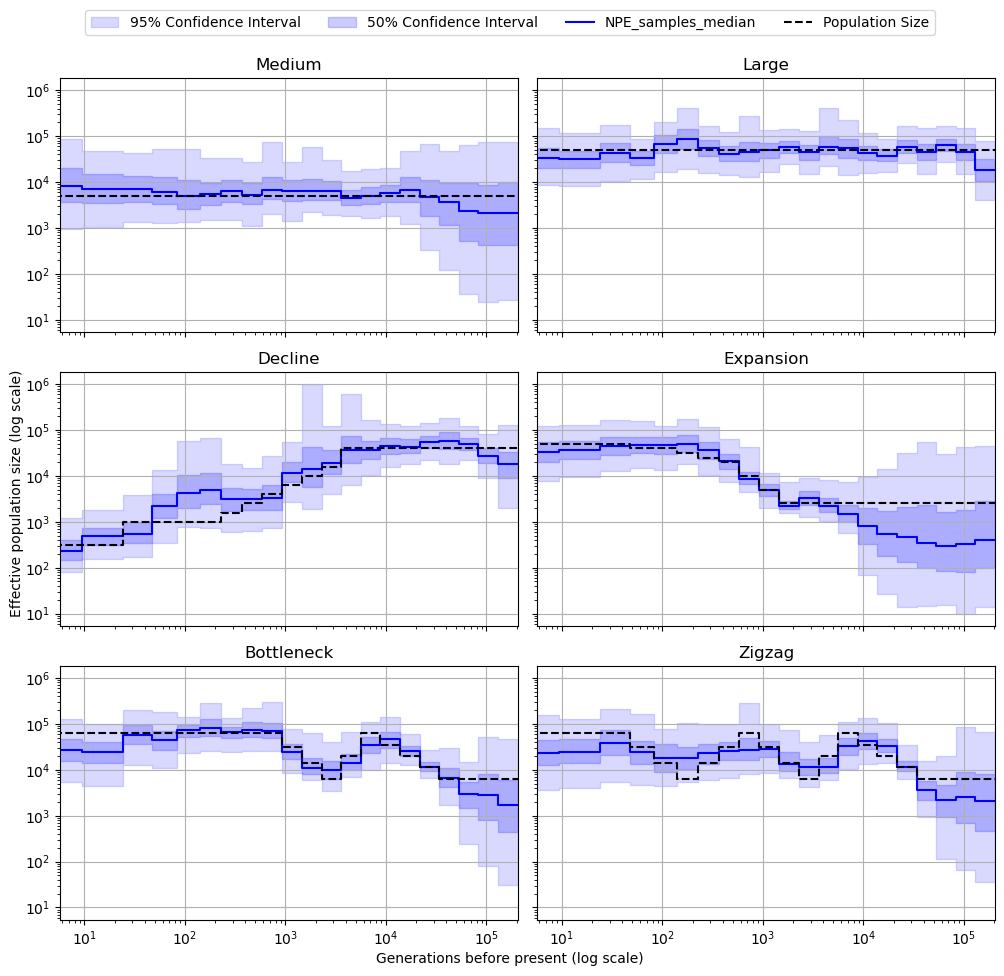

In [76]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    samples = pretrained_posterior.sample((1000,), x=sumstats.loc[sce])
    samples = np.exp(samples * train_std.numpy() + train_mean.numpy())
    pred_with_CI(ax, population_time_demo, scenarios[sce], samples)

max_population_time = max(population_time_demo)

# Set the common x-axis limit for all subplots
for ax,sce in zip(axs, scenarios):
    ax.set_xlim(0,max_population_time)
    ax.set_title(sce)

# Collect legend handles and labels from the first axis
handles, labels = axs[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4)

# Set global x and y labels
fig.text(0.5, 0.03, 'Generations before present (log scale)', ha='center')
fig.text(0.0001, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend and labels
plt.show()

## 5. NN trained with different summary statistics

...

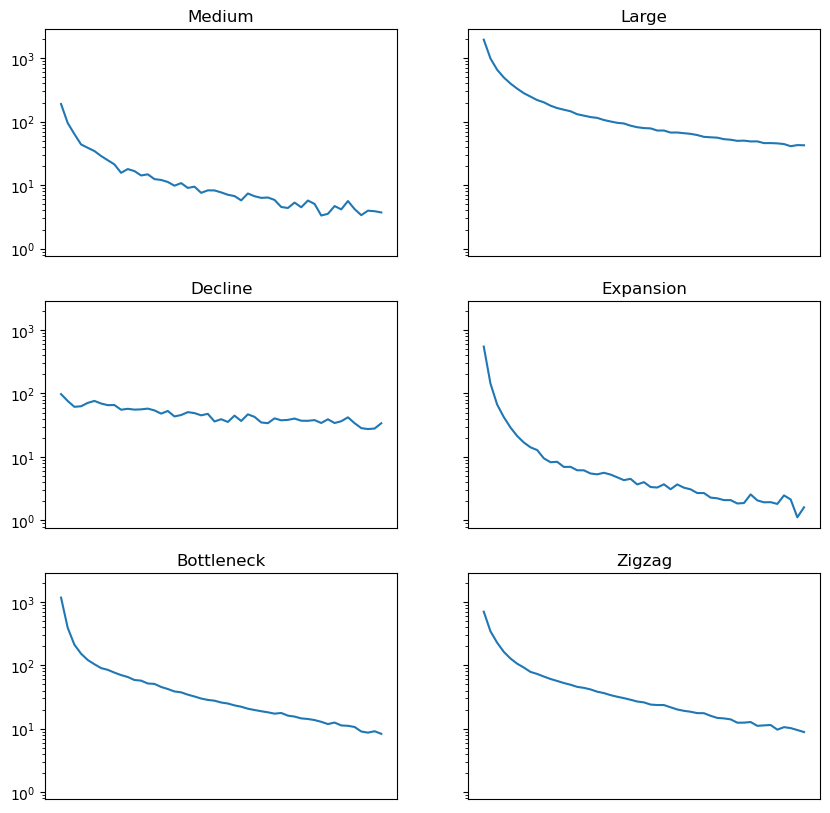

In [89]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    ax.plot(sumstats.iloc[:,:-19].loc[sce])
    ax.set_yscale('log')
    ax.set_xticks([])
    ax.set_title(sce)

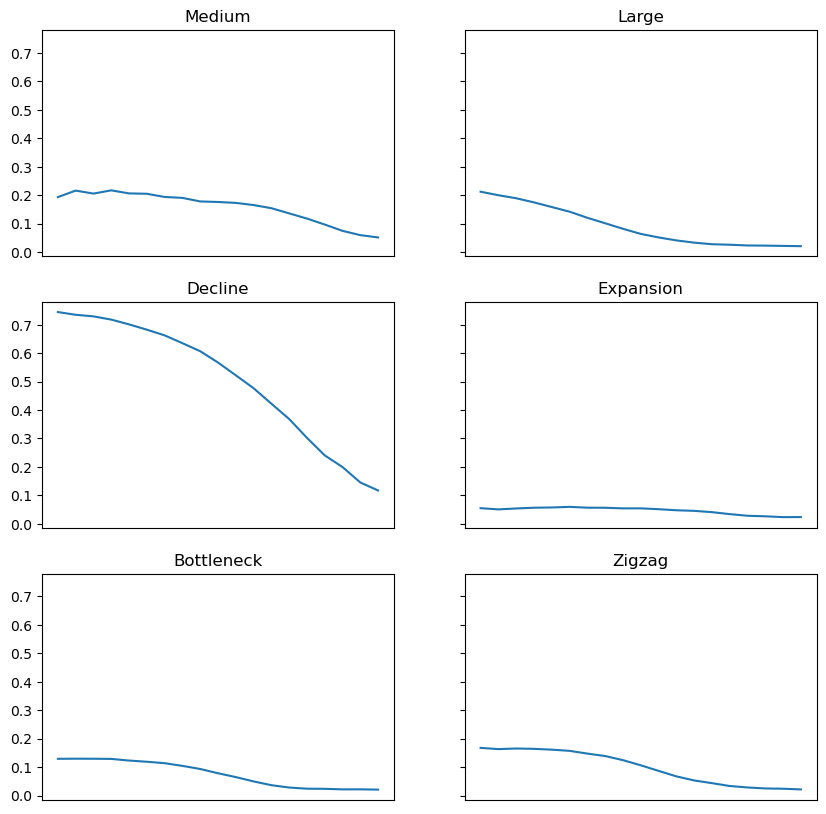

In [95]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    ax.plot(sumstats.iloc[:,-19:].loc[sce])
    ax.set_xticks([])
    ax.set_title(sce)

In [66]:
posterior_AFS_path = 'posterior_AFS.pkl'
with open(posterior_AFS_path, 'rb') as f:
    pretrained_AFS_posterior = pickle.load(f)

posterior_LD_path = 'posterior_LD.pkl'
with open(posterior_LD_path, 'rb') as f:
    pretrained_LD_posterior = pickle.load(f)

/home/ningyuxin/anaconda3/envs/popgensbi/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_7032/3336573943.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,max_population_time)


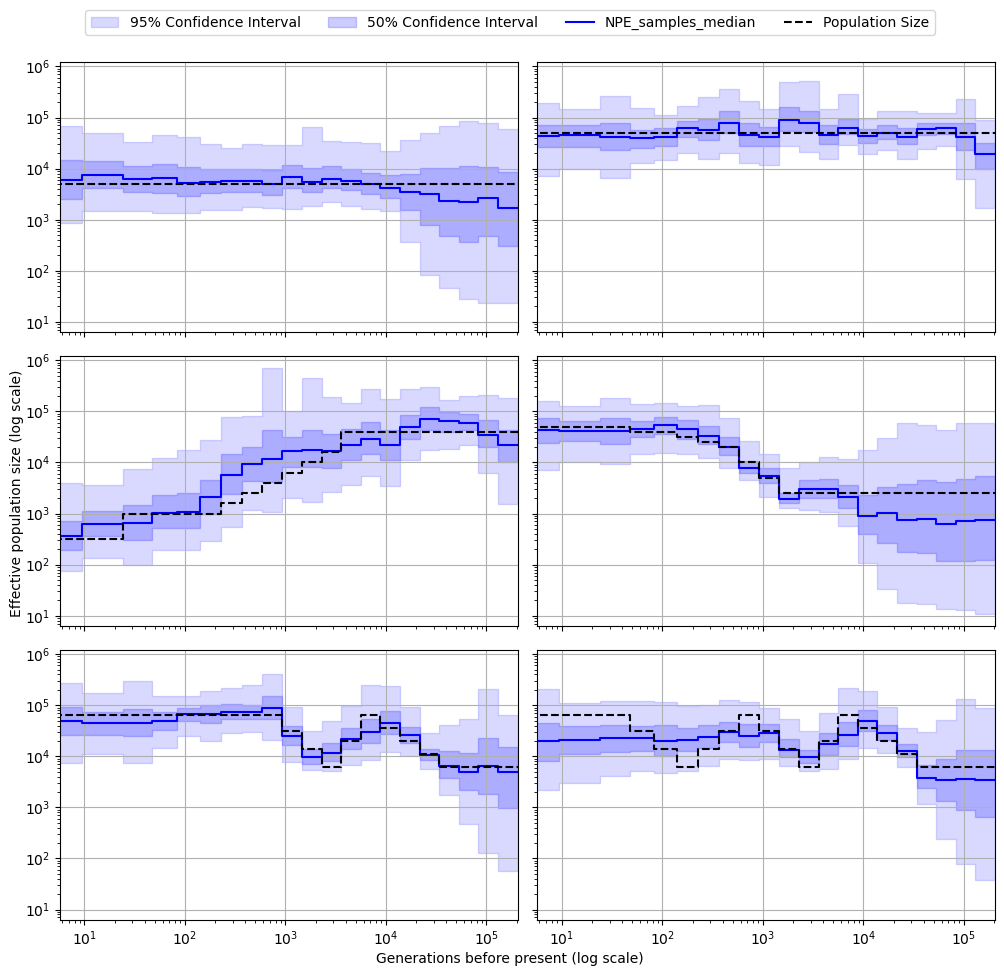

In [69]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    samples = pretrained_AFS_posterior.sample((1000,), x=sumstats.iloc[:,:-19].loc[sce])
    samples = np.exp(samples * train_std.numpy() + train_mean.numpy())
    pred_with_CI(ax, population_time_demo, scenarios[sce], samples)

max_population_time = max(population_time_demo)

# Set the common x-axis limit for all subplots
for ax in axs:
    ax.set_xlim(0,max_population_time)

# Collect legend handles and labels from the first axis
handles, labels = axs[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4)

# Set global x and y labels
fig.text(0.5, 0.03, 'Generations before present (log scale)', ha='center')
fig.text(0.0001, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend and labels
plt.show()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_7032/2947262358.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,max_population_time)


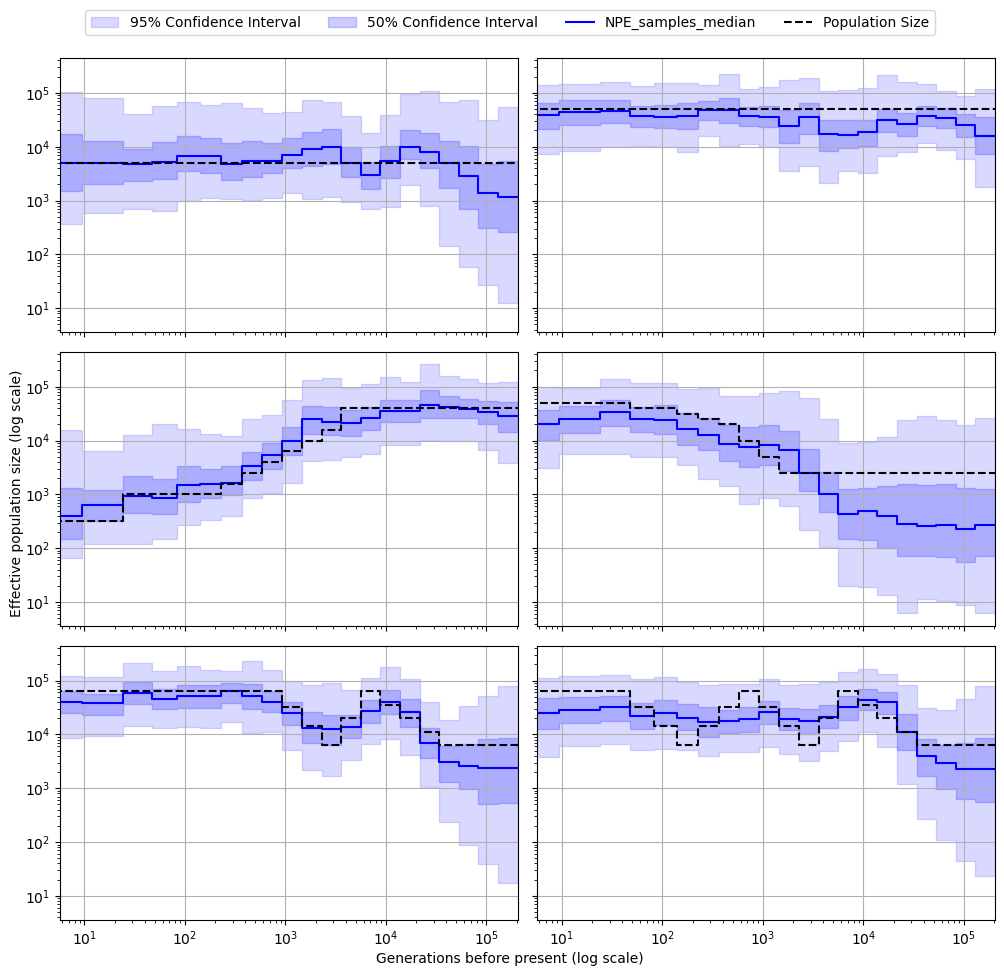

In [70]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, (ax, sce) in enumerate(zip(axs, scenarios)):
    samples = pretrained_LD_posterior.sample((1000,), x=sumstats.iloc[:,-19:].loc[sce])
    samples = np.exp(samples * train_std.numpy() + train_mean.numpy())
    pred_with_CI(ax, population_time_demo, scenarios[sce], samples)

max_population_time = max(population_time_demo)

# Set the common x-axis limit for all subplots
for ax in axs:
    ax.set_xlim(0,max_population_time)

# Collect legend handles and labels from the first axis
handles, labels = axs[0].get_legend_handles_labels()

# Create a single legend for the entire figure
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=4)

# Set global x and y labels
fig.text(0.5, 0.03, 'Generations before present (log scale)', ha='center')
fig.text(0.0001, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend and labels
plt.show()

Thank you for following along! We hope this tutorial helps you get started with the SBI Snakemake pipeline for population genetics.

---

## 6. More fancy applications ...

- [ ] Andy's pipeline, a brief introduction of what can be done.